# Read Data from the Cloud

Specify path and "open" the cloud file. In here opening means it builds a descriptor
by using some information from the binary file header to be able to read anything else
from the file.

In [1]:
import fsspec
import pandas as pd
from IPython.display import JSON
import json
from segy_ninja.standards.rev1 import open_rev1

path = "gs://tgs-datascience-zarr-experiments/segy/filt_mig_nopad_tgsbytes.sgy"

segy_descr = open_rev1(path)

Let's investigate the JSON version of the descriptor.

Some things to note:
1. It parsed using **default** SEG-Y Revision 1 headers.
2. Some headers are defined wrong (we will see in next sections).
3. Way to many headers to deal with!

Note that we can build this JSON independently, load it into the descriptor
and open any SEG-Y with a shema.

In [2]:
JSON(json.loads(segy_descr.model_dump_json()))

<IPython.core.display.JSON object>

Using the descriptor (i.e. SEG-Y layout schema) we can read all sorts of things.

We "open" the binary file and parse out:
- Textual file header
- Binary file header
- 2,000 traces (headers + data)

In [3]:
with fsspec.open(path, mode="rb") as fp:
    text_hdr = segy_descr.text_file_header.read(fp)
    bin_hdr = segy_descr.binary_file_header.read(fp)
    trcs = segy_descr.traces.read(fp, 2_000)

Let's print the textual header. 

As we see, the inline, crossline, X, and Y coordinates are not standard.

In [4]:
print(text_hdr)

C 1 CLIENT: ROCKY MOUNTAIN OILFIELD TESTING CENTER                              
C 2 PROJECT: NAVAL PETROLEUM RESERVE #3 (TEAPOT DOME); NATRONA COUNTY, WYOMING  
C 3 LINE: 3D                                                                    
C 4                                                                             
C 5 THIS IS THE FILTERED POST STACK MIGRATION                                   
C 6                                                                             
C 7 INLINE 1, XLINE 1:   X COORDINATE: 788937  Y COORDINATE: 938845             
C 8 INLINE 1, XLINE 188: X COORDINATE: 809501  Y COORDINATE: 939333             
C 9 INLINE 188, XLINE 1: X COORDINATE: 788039  Y COORDINATE: 976674             
C10 INLINE NUMBER:    MIN: 1  MAX: 345  TOTAL: 345                              
C11 CROSSLINE NUMBER: MIN: 1  MAX: 188  TOTAL: 188                              
C12 TOTAL NUMBER OF CDPS: 64860   BIN DIMENSION: 110' X 110'                    
C13                         

We can look at headers with Pandas in a nicely formatted table. 

We can also do typical Pandas analytics but it won't be shown here.

In [5]:
df = pd.DataFrame(bin_hdr, copy=False)
df

,job_id,line_no,reel_no,data_traces_ensemble,aux_traces_ensemble,sample_interval,sample_interval_orig,samples_per_trace,samples_per_trace_orig,data_sample_format,...,correlated_traces,binary_gain,amp_recovery_method,measurement_system,impulse_signal_polarity,vibratory_polarity,seg_y_revision,fixed_length_trace_flag,extended_textual_headers,additional_trace_headers
0,9999,9999,1,188,0,2000,0,1501,1501,1,...,2,1,4,2,1,0,0,0,0,0


In [6]:
df = pd.DataFrame(trcs["header"], copy=False)
df

,trace_seq_line,trace_seq_file,field_rec_no,trace_no_field_rec,energy_src_pt,cdp_ens_no,trace_no_ens,trace_id,vert_sum,horiz_stack,...,transduction_constant_exponent,transduction_units,device_trace_id,times_scalar,source_type_orientation,source_energy_direction_mantissa,source_energy_direction_exponent,source_measurement_mantissa,source_measurement_exponent,source_measurement_unit
0,0,153,60,153,1,153,153,1,0,4,...,0,0,0,1,0,10027008,0,0,0,0
1,0,154,60,154,1,154,154,1,0,6,...,0,0,0,1,0,10092544,0,0,0,0
2,0,155,60,155,1,155,155,1,0,9,...,0,0,0,1,0,10158080,0,0,0,0
3,0,156,60,156,1,156,156,1,0,11,...,0,0,0,1,0,10223616,0,0,0,0
4,0,157,60,157,1,157,157,1,0,13,...,0,0,0,1,0,10289152,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,8456,60,184,45,8456,184,1,0,68,...,0,0,0,45,0,12058624,0,0,0,0
1996,0,8457,60,185,45,8457,185,1,0,47,...,0,0,0,45,0,12124160,0,0,0,0
1997,0,8458,60,186,45,8458,186,1,0,35,...,0,0,0,45,0,12189696,0,0,0,0
1998,0,8578,60,118,46,8578,118,1,0,92,...,0,0,0,46,0,7733248,0,0,0,0


Let's plot the traces.

Note that they are all parsed from IBM floats to IEEE floats (decoded) in the background.

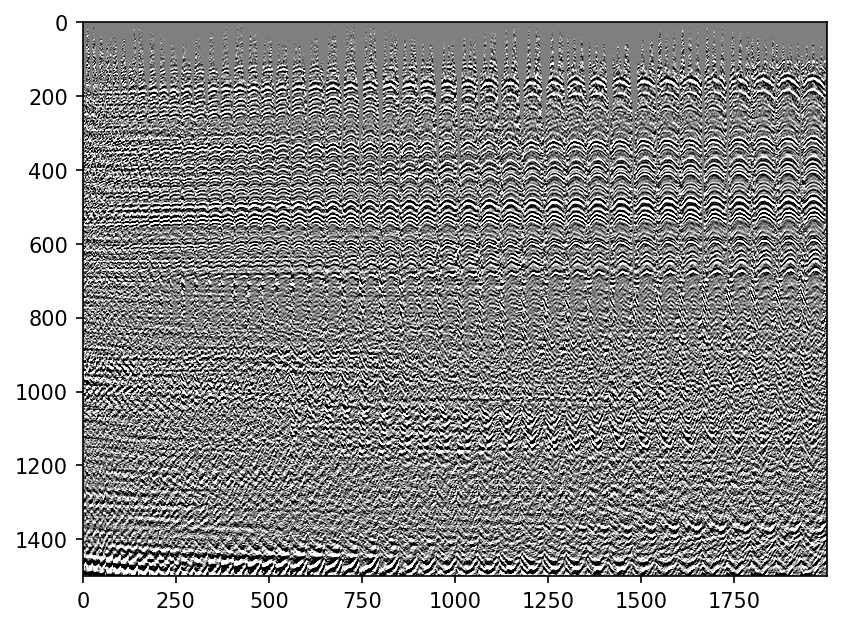

In [7]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)
plt.imshow(trcs["data"].T, aspect="auto", vmin=-1, vmax=1, cmap="gray_r", interpolation="lanczos");

# ReDo the Same with Custom Schema

Let's re-define the binary and trace headers to read ONLY the parts we want.

From the binary file header we will read:
- Number of samples
- Sample rate

From the trace headers, we will 

In [8]:
from segy_ninja.schema.header import (
    TraceHeaderDescriptor,
    HeaderFieldDescriptor, 
    BinaryHeaderDescriptor
)

custom_binary_hdr = BinaryHeaderDescriptor(
    item_size=400,
    offset=3200,
    fields=[
        HeaderFieldDescriptor(name="sample_interval", offset=16, format="int16"),
        HeaderFieldDescriptor(name="samples_per_trace", offset=20, format="int16"),
    ]
)

custom_trace_hdr = TraceHeaderDescriptor(
    item_size=240,
    fields=[
        HeaderFieldDescriptor(name="inline", offset=16, format="int32"),
        HeaderFieldDescriptor(name="crossline", offset=12, format="int32"),
        HeaderFieldDescriptor(name="cdp-x", offset=80, format="int32"),
        HeaderFieldDescriptor(name="cdp-y", offset=84, format="int32"),
    ]
)

segy_descr = open_rev1(
    path,
    binary_file_header=custom_binary_hdr,
    trace_header_descriptor=custom_trace_hdr,
)

Now let's look at the JSON for the desciptor again. It is a lot more concise.

In [9]:
JSON(json.loads(segy_descr.model_dump_json()))

<IPython.core.display.JSON object>

As mentioned earlier, the JSON can be laded into the descriptor from a file too.

```python
from segy_ninja.schema.segy import SegyDescriptor
import os

json_path = "..."

with open(json_path, mode="r") as fp:
    data = fp.read()
    sgy = SegyDescriptor.model_validate_json(data)
```

Let's repeat the previous steps to read headers and some traces and view them.

Headers will be limited to our schema and names will be all correct.

In [10]:
with fsspec.open(path, mode="rb") as fp:
    text_hdr = segy_descr.text_file_header.read(fp)
    bin_hdr = segy_descr.binary_file_header.read(fp)
    trcs = segy_descr.traces.read(fp, 2_000)

In [11]:
df = pd.DataFrame(bin_hdr, copy=False)
df

,sample_interval,samples_per_trace
0,2000,1501


In [12]:
df = pd.DataFrame(trcs["header"], copy=False)
df

,inline,crossline,cdp-x,cdp-y
0,1,153,8056526,9392424
1,1,154,8057625,9392450
2,1,155,8058725,9392476
3,1,156,8059825,9392502
4,1,157,8060925,9392528
...,...,...,...,...
1995,45,184,8089467,9441620
1996,45,185,8090567,9441645
1997,45,186,8091666,9441671
1998,46,118,8016862,9440996


We can now even plot the `cdp-x` and `cdp-y` headers for traces we read in.

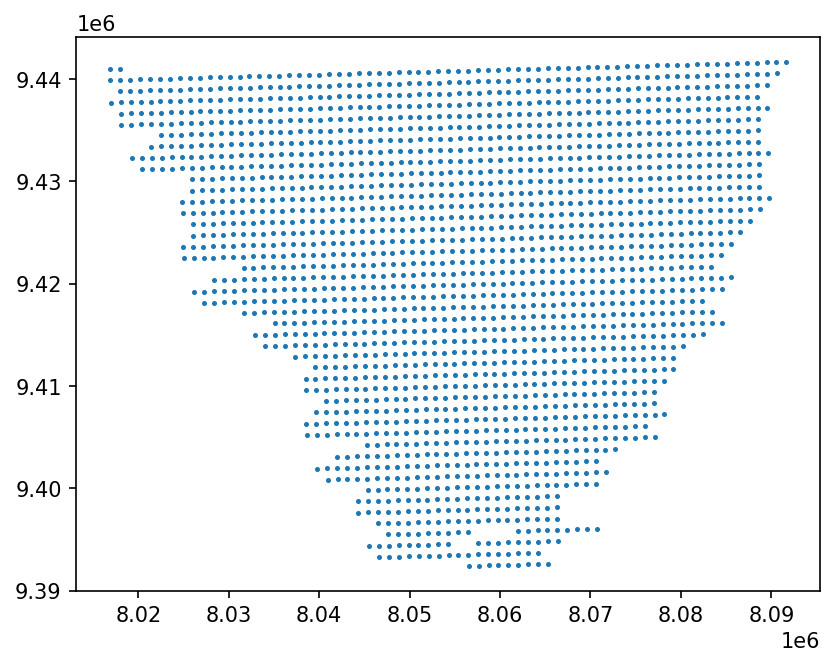

In [13]:
plt.figure(dpi=150)
plt.scatter(df["cdp-x"], df["cdp-y"], s=2);